新模型（FER2013）
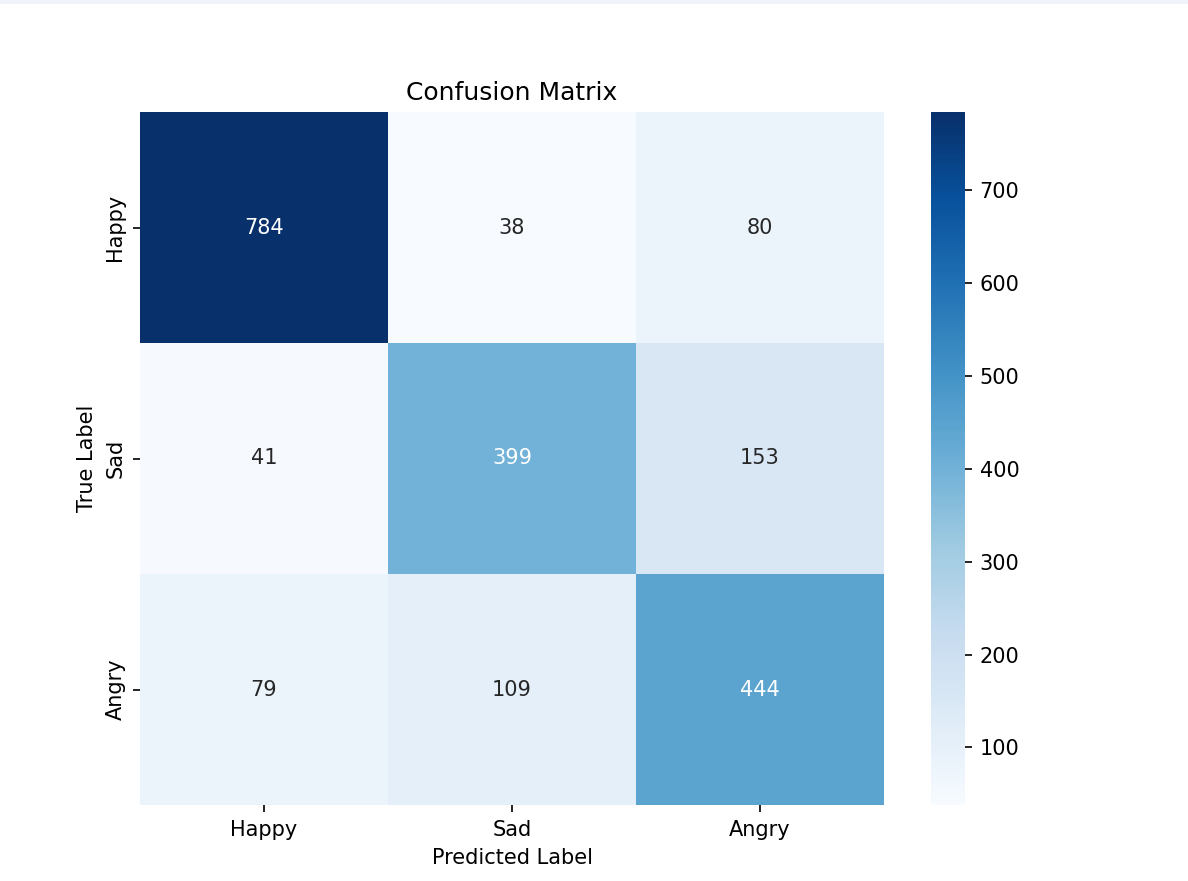
## 1. **导入必要的库**

```python
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
```

**优势：**
- **多样化的库支持**：结合了数据处理（如`numpy`、`pandas`）、机器学习模型选择与评估（如`sklearn`）、深度学习模型构建与训练（如`keras`）、以及可视化（如`matplotlib`、`seaborn`）等多个领域的库，提供了全面的工具支持。
- **模块化设计**：通过导入不同的模块，代码具备良好的可扩展性和可维护性。

## 2. **参数设置**

```python
num_features = 64
num_labels = 3  # 'happy', 'sad', 'angry'
batch_size = 64
epochs = 30
width, height = 48, 48
```

**优势：**
- **可调性强**：通过参数的设置，可以方便地调整模型的复杂度、训练的批次大小、训练轮数等，以适应不同的数据集和任务需求。

## 3. **数据加载与预处理**

```python
# 加载预处理数据
x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

# 数据归一化
x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

# 保存测试集
np.save('modXtest', X_test)
np.save('modytest', y_test)
```

**优势：**
- **数据归一化**：通过减去均值并除以标准差，使得数据具有零均值和单位方差，有助于加快模型的收敛速度并提升训练效果。
- **数据集划分**：将数据分为训练集、验证集和测试集，有助于评估模型的泛化能力，防止过拟合。
- **随机性控制**：通过设定随机种子（`random_state`），保证数据划分的可重复性。

## 4. **构建卷积神经网络（CNN）模型**

```python
model = Sequential()

# 第一组卷积层
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# 第二组卷积层
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# 第三组卷积层
model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# 第四组卷积层
model.add(Conv2D(8*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# 全连接层
model.add(Flatten())
model.add(Dense(8*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))
```

**使用的方法及其优势：**

1. **卷积层（Conv2D）**：
   - **功能**：提取图像的空间特征，如边缘、纹理等。
   - **优势**：能够有效捕捉局部特征，参数共享减少了模型的复杂度。

2. **批归一化（BatchNormalization）**：
   - **功能**：在每一层后标准化输入，加速训练并稳定模型。
   - **优势**：减少内部协变量偏移（Internal Covariate Shift），允许使用更高的学习率，减少对初始化的敏感性。

3. **池化层（MaxPooling2D）**：
   - **功能**：降低特征图的空间维度，减少计算量和防止过拟合。
   - **优势**：保留重要特征，增强特征的平移不变性。

4. **Dropout层**：
   - **功能**：在训练过程中随机丢弃一定比例的神经元，防止过拟合。
   - **优势**：增强模型的泛化能力，减少对训练数据的依赖。

5. **全连接层（Dense）**：
   - **功能**：整合提取到的特征，进行最终的分类。
   - **优势**：具备高表达能力，能够学习复杂的非线性关系。

6. **L2正则化（kernel_regularizer=l2(0.01)）**：
   - **功能**：在损失函数中加入权重的平方和，惩罚过大的权重值。
   - **优势**：防止模型过拟合，提高模型的泛化能力。

7. **激活函数（ReLU和Softmax）**：
   - **ReLU**：加速训练，缓解梯度消失问题。
   - **Softmax**：用于多分类任务，输出概率分布。

## 5. **编译模型**

```python
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
```

**使用的方法及其优势：**

- **损失函数（categorical_crossentropy）**：适用于多分类问题，衡量预测分布与真实分布之间的差异。
- **优化器（Adam）**：
  - **功能**：自适应学习率优化算法，结合了动量和RMSProp的优点。
  - **优势**：在大多数情况下表现良好，适用于处理稀疏梯度和高维参数空间的问题。
- **评估指标（accuracy）**：衡量分类的准确性，直观反映模型性能。

## 6. **训练模型**

```python
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)
```

**优势：**

- **验证集监控**：通过`validation_data`监控模型在验证集上的表现，有助于判断是否过拟合。
- **批次训练**：使用`batch_size`进行小批量梯度下降，提高训练效率和稳定性。
- **数据打乱（shuffle=True）**：每个epoch开始前打乱数据，减少数据顺序对训练的影响，提高模型的泛化能力。

## 7. **保存模型**

```python
# 保存模型架构
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
# 保存模型权重
model.save_weights("fer.h5")
print("Saved model to disk")
```

**优势：**

- **模型持久化**：将模型架构和权重分别保存，便于后续加载和部署。
- **灵活性**：可以在不同环境中重建模型，不依赖于原始代码。

## 8. **模型评估与可视化**

```python
# 预测测试集标签
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Happy', 'Sad', 'Angry'], yticklabels=['Happy', 'Sad', 'Angry'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
```

**优势：**

- **混淆矩阵**：提供详细的分类结果，展示模型在哪些类别上表现良好，哪些类别上存在混淆。
- **可视化**：通过热力图直观展示混淆矩阵，便于理解和分析模型性能。

## **总体优势总结**

1. **深层次的特征提取能力**：通过多层卷积和池化操作，模型能够有效提取图像中的复杂特征，提升分类性能。

2. **正则化技术**：
   - **Dropout**和**L2正则化**有效防止过拟合，提高模型的泛化能力。
   - **Batch Normalization**不仅加速训练，还稳定了模型的学习过程。

3. **优化算法的选择**：Adam优化器结合了动量和自适应学习率的优点，适用于多种任务，提升了训练效率和效果。

4. **全面的数据处理**：包括数据归一化、数据集划分、数据打乱等步骤，确保模型训练的稳定性和有效性。

5. **模型的持久化和复用性**：通过保存模型架构和权重，便于模型的后续加载、评估和部署。

6. **详细的评估与可视化**：通过混淆矩阵等评估手段，全面了解模型的分类性能，指导后续的模型优化。


这两个代码实现的都是情感识别的卷积神经网络（CNN）模型，但它们在结构、训练方式、数据处理和功能上有一些重要的区别。以下是这两个模型的详细比较：
新  旧
### 1. **模型架构**

**第一个模型：**
- 使用了多层卷积层，每一组卷积层之间都有`BatchNormalization`（批归一化）和`Dropout`层。
- 有4组卷积层，最后三组卷积层的滤波器数量是2的幂次增长，分别为128、256、512。
- 在全连接层之前，有三个全连接层，每个全连接层后面都有`Dropout`层。
- 输出层有3个神经元（`softmax`激活函数），对应3种情感类别（`happy`, `sad`, `angry`）。

**第二个模型：**
- 仅有3组卷积层，分别有32、64和128个滤波器，采用了更简单的架构。
- 每组卷积层后面都有一个最大池化层和`Dropout`层。
- 在全连接层之前，有一个`Flatten`层和一个1024个神经元的全连接层，并附带`Dropout`层。
- 输出层也有3个神经元（`softmax`激活函数），对应3种情感类别。

**总结：**第一个模型更复杂，包含更多层和更多的参数，而第二个模型较为简洁，更适合快速实验和较小数据集。

### 2. **数据处理**

**第一个模型：**
- 数据在代码中已经预处理过（`fdataX.npy`和`flabels.npy`），使用的是标准的`numpy`数组，并进行了归一化处理。
- 数据集的划分是通过`train_test_split`函数进行的，手动将数据集分为训练集、验证集和测试集。

**第二个模型：**
- 使用了`ImageDataGenerator`从目录中直接加载和生成图像数据，包含数据增强功能（虽然当前只做了归一化处理）。
- 数据分为训练和验证集，数据生成器自动处理数据的批量加载和预处理。

**总结：**第二个模型通过`ImageDataGenerator`处理数据，更加方便处理大规模数据集和数据增强，而第一个模型则需要手动管理数据加载和预处理。

### 3. **训练方式**

**第一个模型：**
- 直接使用`model.fit`方法训练模型，训练过程包括多个`epoch`。
- 在整个训练过程中，数据在每个`epoch`内都被打乱并重新输入模型。

**第二个模型：**
- 采用了每个`epoch`单独训练的方式，并手动计算和记录每个`epoch`的精度和损失，尤其是对每个类别（`angry`, `happy`, `sad`）单独记录。
- 模型的每个`epoch`结束后，还会重新设置验证数据生成器，手动计算并绘制混淆矩阵。

**总结：**第二个模型更注重每个`epoch`的详细评估和监控，而第一个模型则是标准的连续训练方式。

### 4. **功能和用途**

**第一个模型：**
- 主要用于训练和评估情感识别的效果，没有涉及到实时应用。

**第二个模型：**
- 增加了命令行参数，可以选择“train”或“display”模式。
- `display`模式支持使用摄像头实时检测人脸，并预测实时情感分类，这是更为实际的应用场景。

**总结：**第二个模型不仅用于训练，还可以实时应用于情感识别，这增加了它的实用性。

### 5. **优化器和损失函数**

**两个模型：**
- 都使用了`Adam`优化器和`categorical_crossentropy`损失函数，这在多分类问题中是常见的选择。
- 不同的是，第一个模型的学习率设置为0.001，而第二个模型的学习率设置为0.0001，第二个模型的学习率更低，可能更适合细致的模型调整。

### **结论**

- **第一个模型**：更适合深度学习研究和实验，使用了更复杂的网络架构和数据处理方法，注重模型的深层次特征提取和性能优化。
- **第二个模型**：更加实用和便捷，尤其适合初学者或应用于实际场景，如实时情感识别任务。模型架构较为简单，适用于快速实验和部署。


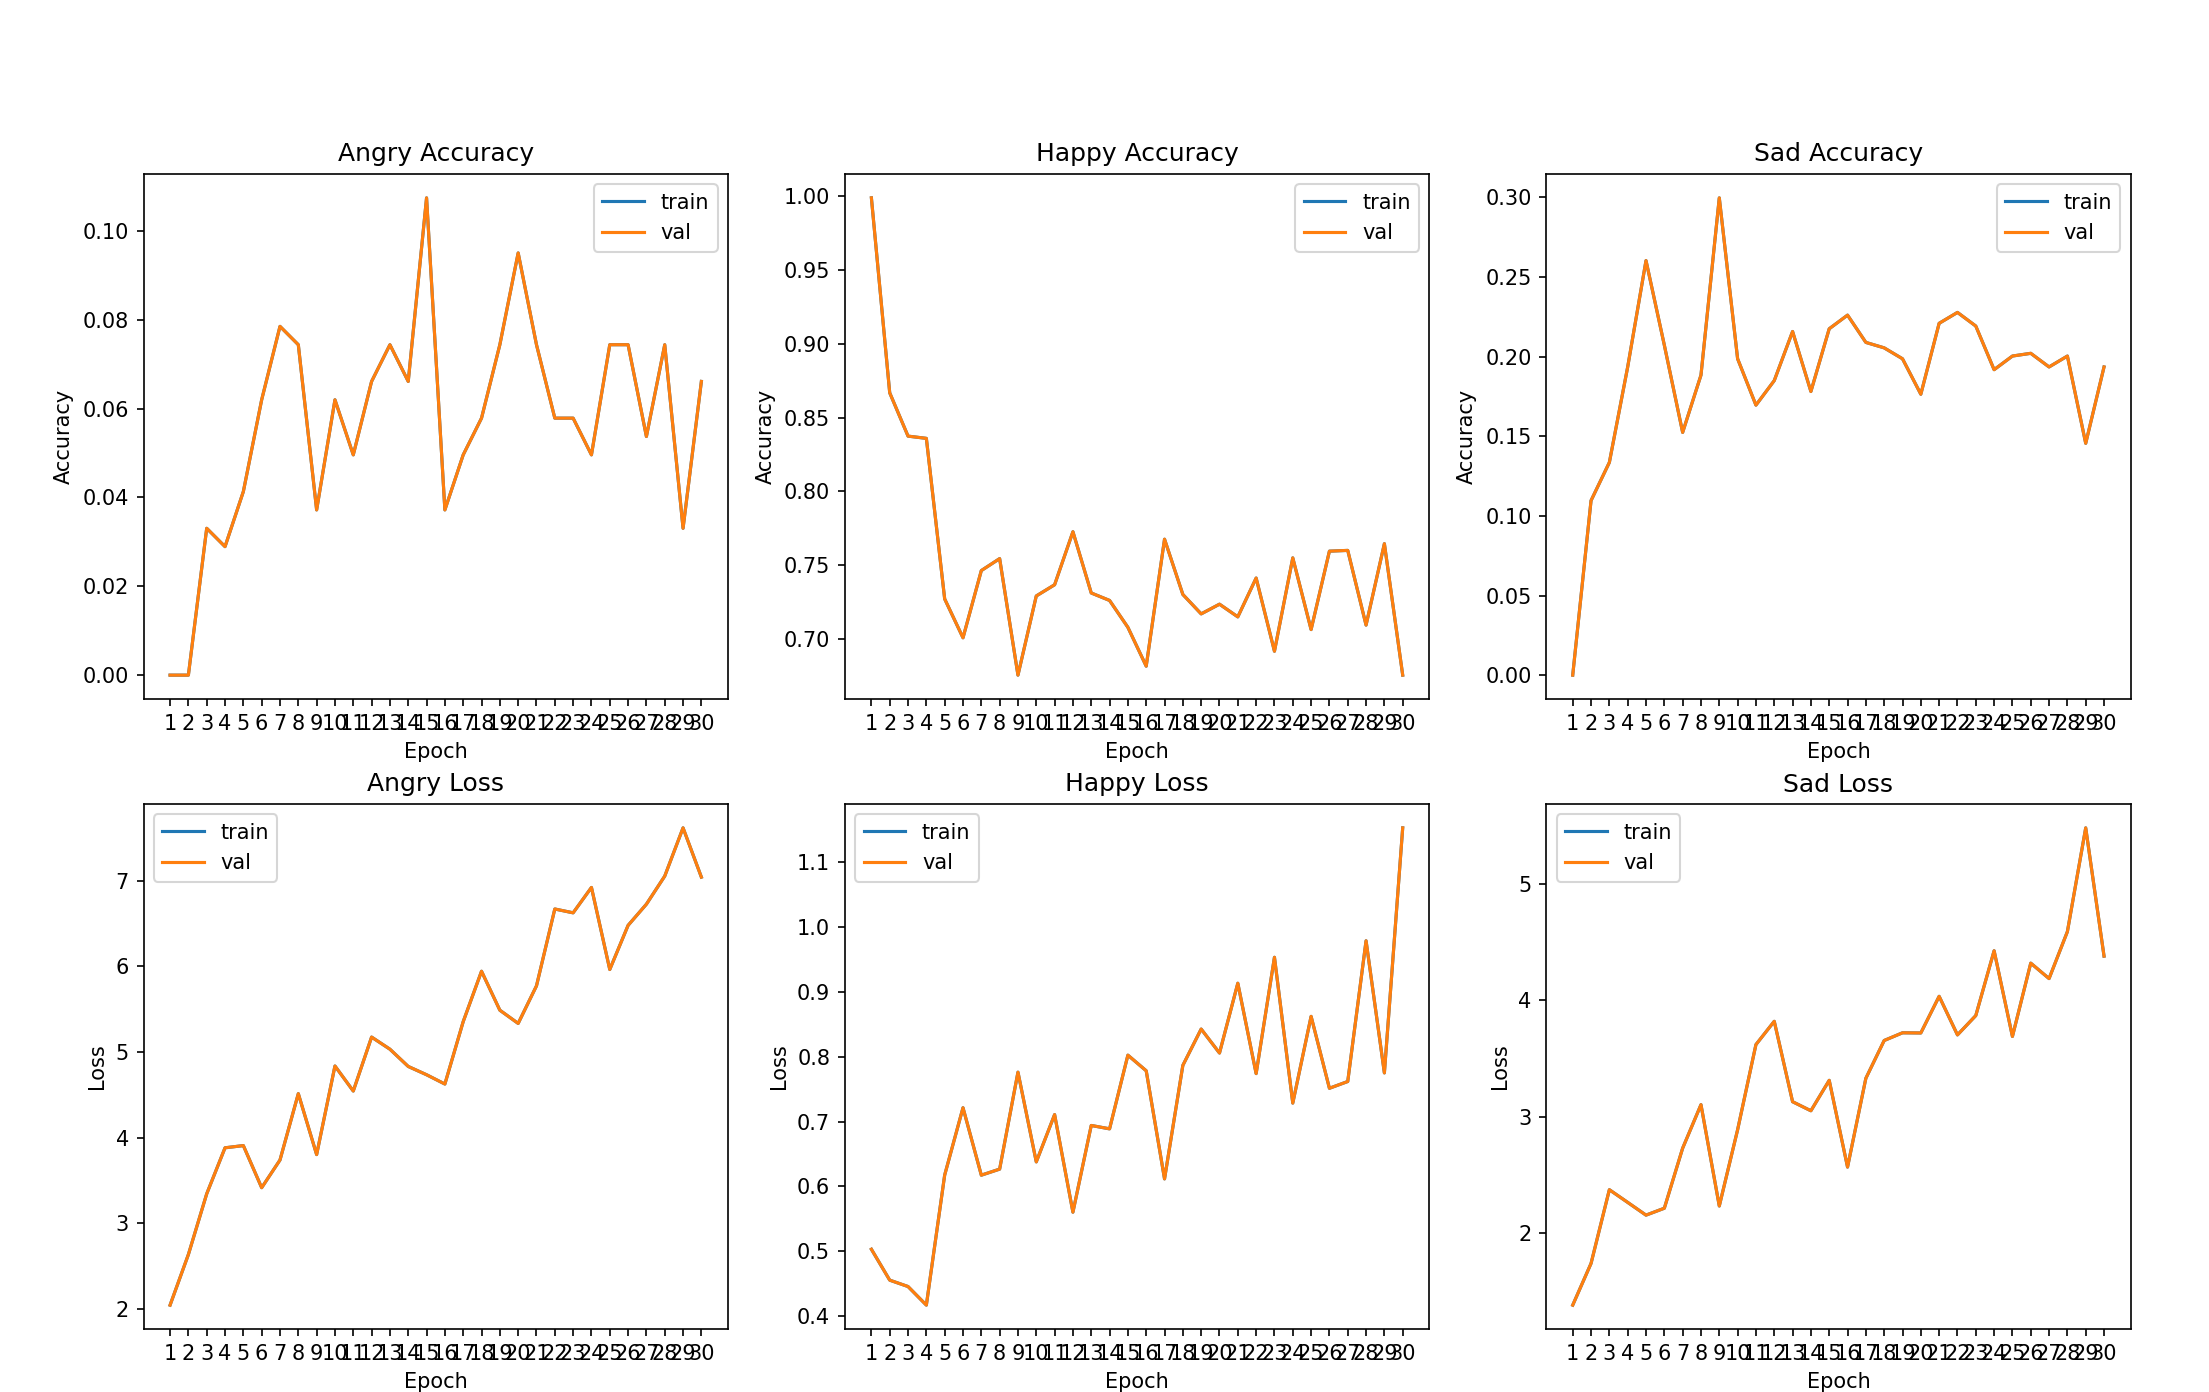

第一个模型sad和angry表现得都非常不好，

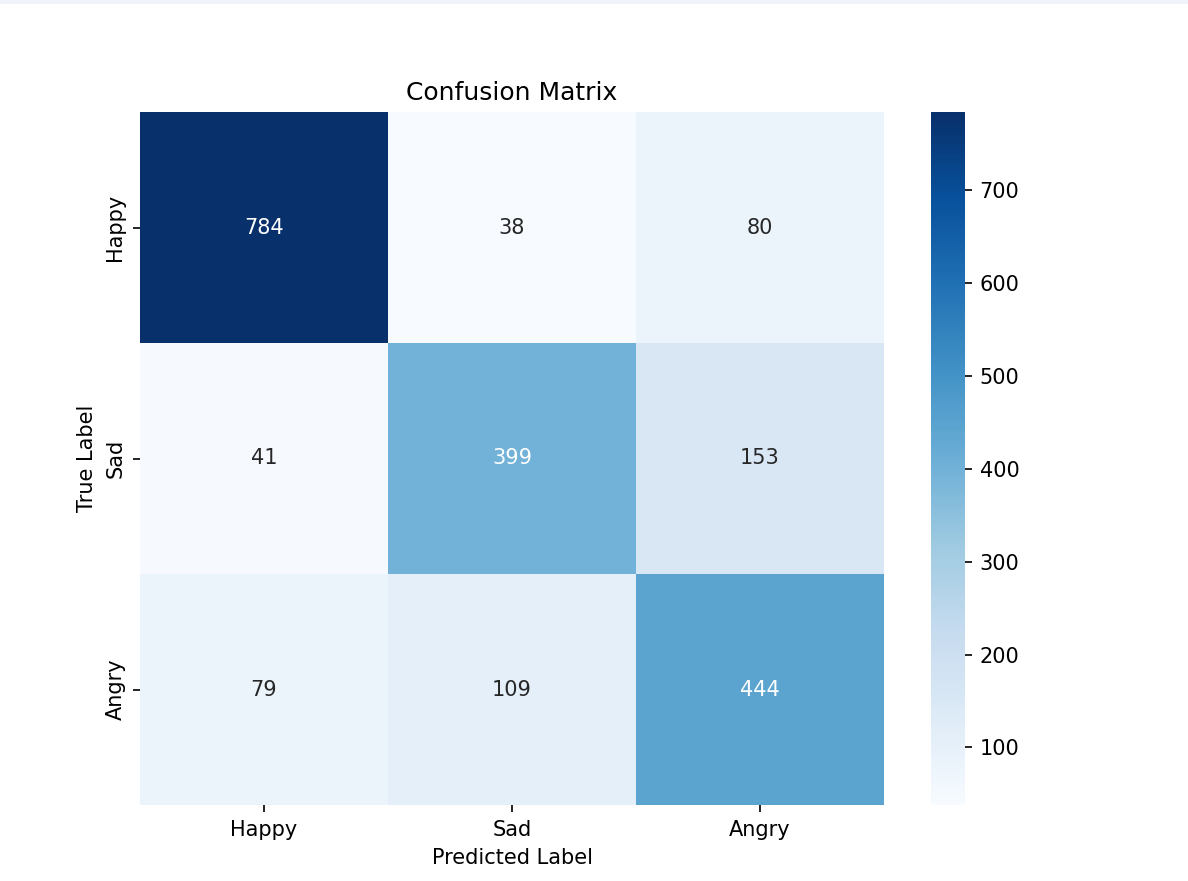

第二个模型有了非常大的改善

注意：这两个模型用的数据集合都是FER2013. epoch都是30 batch_size也一致   记得突出我们的控制变量